# Setup and workflow

## Main goals

The BOLD signal contains noise. Here, we calculate correlations between subjects to reduce noise and estimate task-relevant signals. Want to find brain regions where the same levels of activity are displayed. Key predictions are that, in the theory encoding region, the ISC should:

1. Be highest for same levels, medium for same games, and lowest for random (shuffled) games
2. Increase over levels of the same game

---

## Workflow

1. Load data in notebook (we are dealing with `.mat` files) (**Remark.** note that files are different (glm1 != glm24)
2. Do fMRI data exploration (how does the structure look like, etc.)
    - preprocessing
3. Do ISC analysis; see (Chen et al., 2017) and [Brainiak ISC tutorial](https://brainiak.org/tutorials/10-isc/)
4. Do Searchlight analysis []

[Brainiak ISC analyasis documentation](https://brainiak.org/docs/brainiak.html#module-brainiak.isc)

[Brainiak specific examples](https://github.com/brainiak/brainiak/tree/master/examples)

In [5]:
import brainiak

In [6]:
import h5py
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os 
import glob
import time
from copy import deepcopy
import numpy as np
import pandas as pd 

from nilearn import datasets
from nilearn import surface
from nilearn import plotting
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
import nibabel as nib

from brainiak import image, io
#from brainiak.isc import isc, isfc, permutation_isc
import matplotlib.pyplot as plt
import seaborn as sns 

%autosave 30
%matplotlib inline
sns.set(style = 'white', context='talk', font_scale=1, rc={"lines.linewidth": 2})

Autosaving every 30 seconds


# 0. Loading in the data

In [7]:
data_dir = '/Users/Daphne/Desktop/beta_series/' # local directory
os.path.exists(data_dir) 

True

from [here](https://stackoverflow.com/questions/874461/read-mat-files-in-python) and [scipy docu](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.io.loadmat.html)
```
Neither scipy.io.savemat, nor scipy.io.loadmat work for MATLAB arrays version 7.3. But the good part is that MATLAB version 7.3 files are hdf5 datasets. So they can be read using a number of tools, including NumPy.
```

[h5py documentation](http://docs.h5py.org/en/stable/quick.html#core-concepts)

We want to access the following variables in the dataset (8 subjects):
- `B = [blocks, voxels]`:  the average activity in each block (BOLD signal). The whole brain data.
    - rows: game (block)
    - cols: voxels
- `names = [18,1]` : the names of the games
- `Vmask = [1,1] array with 8 fields` : can be used to convert mask to standardised brain coordinates
- `mask = [79, 95, 79]` : binary mask that was used to get `B` from all the fMRI data.

In [8]:
# specify filename
filename = 'beta_series_glm1_subj1_nosmooth.mat'

In [9]:
# each subject is a separate file so
subject = h5py.File(data_dir+filename,'r')

list(subject.keys()) # these are the variables in the data

['#refs#', 'B', 'Vmask', 'mask', 'names']

In [10]:
# now we read in all the variables of interest for a given subject
B = subject['B'].value

mask = subject['mask'].value
names = subject['names'].value
Vmask = subject['Vmask']

# # alternatively, using dictionary syntax..
# B = subject['B']

# Vmask is nested
list(Vmask.keys())

['descrip', 'dim', 'dt', 'fname', 'mat', 'n', 'pinfo', 'private']

In [11]:
Vmask['dim']

<HDF5 dataset "dim": shape (3, 1), type "<f8">

In [12]:
# get all the data for GLM1 (subjects 1-8)
num_subjects = 8

B_data = []
mask_data = []
Vmask_data = []
names_data = []

for i in range(num_subjects):
    idx = i+1
    
    # change filename to subject #
    data_dir = '/Users/Daphne/Desktop/beta_series/'
    filename = 'beta_series_glm1_subjk_nosmooth.mat'
    filename = filename.replace('k', str(idx))
    
    subject = h5py.File(data_dir+filename,'r') 
    print(f'Get data for subject {idx}')
    # load and save data for respective subject
    B = subject['B'].value
    mask = subject['mask'].value
    names = subject['names'].value
    Vmask = subject['Vmask']
    
    # append to lists
    B_data.append(B)
    mask_data.append(mask)
    Vmask_data.append(Vmask)
    names_data.append(names)

Get data for subject 1
Get data for subject 2
Get data for subject 3
Get data for subject 4
Get data for subject 5
Get data for subject 6
Get data for subject 7
Get data for subject 8


Check data shapes (sanity check)

In [13]:
B_data[0].shape

(179595, 18)

In [14]:
mask_data[0].shape

(79, 95, 79)

In [15]:
Vmask_data[0]

<HDF5 group "/Vmask" (8 members)>

In [16]:
names_data[0].shape

(1, 18)

We stick to the recommended sequence of steps for running ISC using Brainiak
1. **Data preparation**. Create a whole-brain mask. The outcome of this is an array of anatomically-aligned and temporally-aligned brain data.
2. **Compute ISC**. The ISC function computes correlations across subjects for corresponding voxels in the mask. It uses the compute_correlation function in BrainIAK, which is optimized for fast execution (and was used in FCMA).
3. **Permutation test for ISC**. Perform statistical analysis to determine significant correlation values for ISC


# 1. Data preparation

- The mask var (`mask_data`) is a **binary mask** computed from the brain volume. It contains 0s for voxels that we don't want to analyse and 1s for the areas we are interested in. Convolving the mask with the voxels should create `mask_images`

We extract the BOLD data, only for the voxels in a mask in the following way: 

1. Load whole brain fMRI data `B` (for a given subject and given run) 
2. Load the mask that specifies the ROI (<font color=red>mPFC, mOFC, Hippocampus, dmPFC, PMC, diPFC, dorsal caudate, ... more? </font>)
3. Use `NiftiMasker` to subselect the voxels of that ROI from the whole brain data.

- Get voxels from a ROI. 

boolean mask > voxel indices > voxel coordinates in native space

In [17]:
# choose a subject for which to inspect the data
subj = 0

In [18]:
B_data[subj].shape

(179595, 18)

In [19]:
B_i = B_data[subj]
B_i

array([[ 13.67853355,   9.34046936,   8.19104671, ...,  13.98070717,
          1.051754  ,   4.48804474],
       [ 19.71709633,  14.8930378 ,  18.61097145, ...,   8.22801685,
         -2.43646121,   3.49442911],
       [  1.22297895,   3.4824307 ,   3.93117332, ...,   8.7571125 ,
          5.50793028,   3.66078162],
       ...,
       [ -9.61049461, -38.04869461, -41.12371445, ...,  22.4010582 ,
         17.33374023, -16.49692345],
       [-14.54338264,  -4.19539356,  -0.50012857, ...,  -3.23373842,
         -7.53230715, -12.56788921],
       [-20.06606102,  -7.664783  ,  -4.73619652, ...,  26.66522789,
         39.77856445,  40.31108856]])

In [20]:
# we can get the coordinates of the voxels by getting the indices where mask == 1
coords = np.where(mask_data[0] == 1) # sidenote: np.where is equivalent to matlabs find()

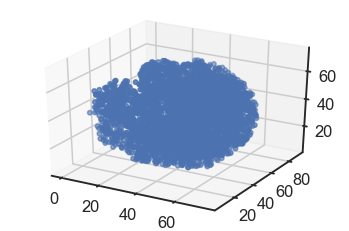

In [21]:
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.scatter3D(coords[0][::50], coords[1][::50], coords[2][::50]);# plot only every 50 indices (faster)

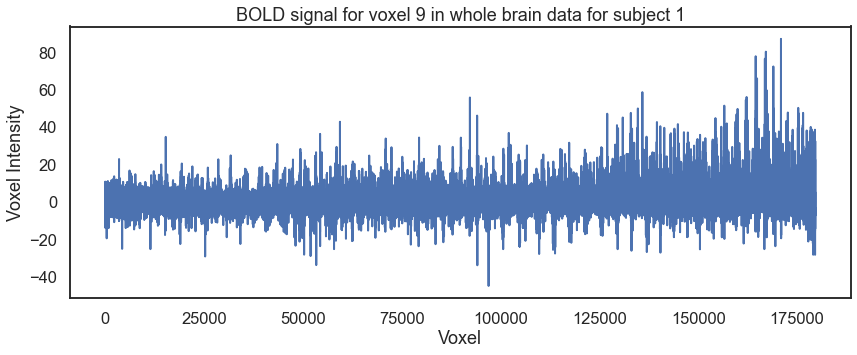

In [22]:
# time series for one voxel on whole brain data
voxel_id = 9

f, ax = plt.subplots(1,1, figsize=(14,5))
ax.plot(B[:, voxel_id])
ax.set_title(f'BOLD signal for voxel {voxel_id} in whole brain data for subject {subj+1}')
ax.set_xlabel('Voxel')
ax.set_ylabel('Voxel Intensity');

## 2. Compute ISC

In principle we should be able to calculate the correlations without computing ROIs. <font color=red>Can we also correlate each voxel to each other respective voxel directly? Without doing the ROIs?</font>

ISC is the correlation of each voxel's time series for a participant with the corresponding (anatomically aligned) voxel time series in the average of the other participants' brains. BrainIAK has functions for computing ISC by feeding in the concatenated participant data.

`B` is the fMRI BOLD data in the form `[games, voxels]`. So we can look at the Bold data for one game like this

In [23]:
B_i = B_i.T # transpose matrix so that we have [games, voxels]

In [24]:
B_i.shape

(18, 179595)

In [25]:
B_i_gameone = B_i[0,:] # first row (game 1), all cols (voxels)

In [26]:
B_i_gameone.shape

(179595,)

In [27]:
# convert list to np array
B_arr = np.array(B_data)

B_arr.shape # 

(8, 179595, 18)

### Methods

Each `run` has 3 `blocks`

Each `block` has 3 `levels`

Each `level` was played for 60 s

If we want to calculate the ISC for each game, then the repetition time (TR) is 

> TR = 180 seconds 

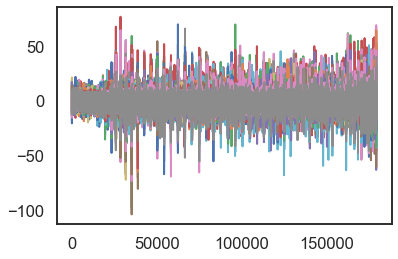

In [41]:
plt.plot(B_arr[0])

In [ ]:
# now massage the data into the right shape 


### About `ISC(data)`

- expects: `data (list or ndarray (n_TRs x n_voxels x n_subjects))` – fMRI data for which to compute ISC

- For each voxel or ROI, compute the Pearson correlation between each subject’s response time series and other subjects’ response time series. 
- Output is an ndarray where the first dimension is the number of subjects or pairs and the second dimension is the number of voxels (or ROIs). If only two subjects are supplied or a summary statistic is invoked, the output is a ndarray n_voxels long.

based on work in (Hasson 2004).

## 3. Permutation test for ISC

## Useful terminology 


- trial: One presentation of the stimulus.
- block: A sequence of trials of the same category. In the 'vdc' study, e.g. a block would consist of all face -- - trials. Usually, multiple blocks are presented to the participant.
- run: A sequence of blocks presented to the participant. 
- TR: Also known as Repetition Time. It is the time interval at which pulses occur and signal is collected. It can thus be considered as the sampling period of the BOLD signal. 